# *Lab 2: Exploring Image Data*


### Buisness Understanding
_________________________

The dataset, **Car Images Dataset**, was gathered by author Kshitij Kumar and published on Kaggle, a platform for data science and machine learning practitioners, researchers, and enthusiasts. The dataset consists of various types of car images from the web in the form of JPEG files. Specifically, this dataset consists of 7 different types of vehicles and in total there are 4,165 images. 

The files for the dataset are seperated into two directories: test and train. Within each directory, the images are seperated into 7 sub directories called: Audi, Hyundai Creta, Mahindra Scorpio, Rolls Royce, Swift, Tata Safari, and Toyota Innova. Each of these sub directories contains varoius jpeg image files of the same type of car make and model. The training dataset consists of 3352 images (814 Audi's, 271 Hyundai Creta's, 316 Mahindra Scorpio's, 311 Rolls Royce's, 424 Swift's, 441 Tata Safari's and 775 Toyota Innova's) and is the directory we will be using to train our classifier to determine the type of vehicle based on an image given. Obviously, there are more makes and models out there but for our chosen dataset we will be working with the 7 different models, with hopes of making this classifier more optimized in the future so that it can handle and identlfy other existings make and models. 

As briefly mentioned, the purpose for choosing this dataset is to build a classfication model that is able to accurately identify the type of car (make and model) based on a vehicle image. Vehicle identification is useful for various reasons and can be of interest to third parties such as law enforcement. Law enforcement agencies use vehicle identification for various purposes, including traffic enforcement, vehicle registration, and investigations. Identifying vehicles involved in accidents, crimes, or traffic violations helps in law enforcement efforts, tracking stolen vehicles, and maintaining public safety. Accurately classifying the make and model of vehicles enables better decision-making, improves operational efficiency, and supports various business objectives and regulatory requirements.

Regarding prediction tasks and performance, our algorithm can predict whether a vehicle is an: Audi (0), Hyundai Creta (1), Mahindra Scorpio (2), Rolls Royce (3), Swift (4), Tata Safari (5), Toyota Innova (6). To be useful to thrid parties such as law enforcement, the algorithm's performance would need to acheive a high level of accuracy in classification in situations where the consequences of misclassification are higher, such as identifying stolen vehicles or vehicles involved in crimes, a high level of accuracy is essential to avoid false positives or false negatives. However, a high amount of false positives could serve useful as well in certain applications of investigation in law enforcemnt, ensuring that no vehicles of interest are missed. 

Ultimately, the idea behind vehicle classification is that so it can used with any vehicle image datasets such as those collected from trafic light cameras, dashcams, cell phones, survailance footage etc. and aid in investigative purposes such as stolen vehicles, smuggling, accidents, traffic violations and other crimal activities where a vehicle is involved. Specifically to law enforcemnt, vehicle classification plays a vital role in law enforcement efforts to maintain order, protect citizens, and uphold the rule of law on the roads and highways. 



### Data Preparation

__________________________________

**Data Preprocessing:** The following code block reads the images from the training and testing directories as numpy arrays. It resizes the images to be 128x128 pixels and changes the coloring to grayscale. It then linearizes the images to create a table of 1-D image features called df_data[] and also splits the 1-D numpy array into sub arrays of each type of vehicle to be used for further analysis and visualization.

In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import resample


def read_images_from_folder(folder_path, grayscale=True):
    images = []
    labels = []
    image_shapes = {}
    for label, make in enumerate(os.listdir(folder_path)):
        make_path = os.path.join(folder_path, make)
        if os.path.isdir(make_path):
            for filename in os.listdir(make_path):
                img_path = os.path.join(make_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    # Convert to grayscale if required
                    if grayscale:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    # Record image shape
                    shape = img.shape
                    if shape not in image_shapes:
                        image_shapes[shape] = 1
                    else:
                        image_shapes[shape] += 1
                    # Append image to list
                    images.append(img)
                    labels.append(label)

    # Find the majority shape
    majority_shape = max(image_shapes, key=image_shapes.get)

    # Filter out images with shapes different from the majority shape
    filtered_images = []
    filtered_labels = []
    for img, label in zip(images, labels):
        if img.shape == majority_shape:
            filtered_images.append(img)
            filtered_labels.append(label)

    # Convert lists to numpy arrays
    images = np.array(filtered_images)
    labels = np.array(filtered_labels)
    return images, labels

def resize_images(images, target_size):
    resized_images = []
    for img in images:
        img = cv2.resize(img, target_size)
        resized_images.append(img)
    return np.array(resized_images)

def linearize_images(images):
    num_images = images.shape[0]
    flattened_size = np.prod(images.shape[1:])
    return images.reshape(num_images, flattened_size)

# Define paths to train and test folders
train_folder = "Cars Dataset/train"
test_folder = "Cars Dataset/test"

# Read images and labels from train and test folders
train_images, train_labels = read_images_from_folder(train_folder)
test_images, test_labels = read_images_from_folder(test_folder)

# Resize images to a common size
target_size = (100, 100)
train_images_resized = resize_images(train_images, target_size)
test_images_resized = resize_images(test_images, target_size)

# Linearize images
train_images_linearized = linearize_images(train_images_resized)
test_images_linearized = linearize_images(test_images_resized)


**Data Visualization:** The following code block visualizes a rendered image of vehicles in each of the 7 makes in our dataset. 

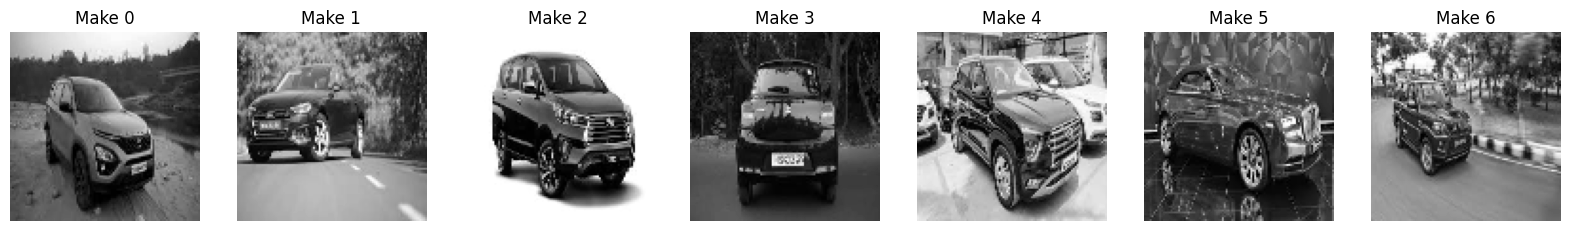

In [4]:
def visualize_images(images, labels, num_images=7):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    unique_labels = np.unique(labels)
    for i, label in enumerate(unique_labels):
        idx = np.where(labels == label)[0][0]  # Get the index of the first occurrence of the label
        axes[i].imshow(images[idx], cmap='gray')  # Show the image
        axes[i].set_title(f"Make {label}")  # Set the title with the make
        axes[i].axis('off')  # Turn off axis
    plt.show()

# Visualize several images
visualize_images(train_images_resized, train_labels)

### Data Reduction 
___________________________

**Linear Dimensionality Reduction of the Images using PCA** and **Visualization Explained Variance**

Principal Compnent Analysis is critical to apply to our dataset as it aims to reduce the number of variables while preserving as much information as possible. With a large dataset such as ours, applying PCA is a great statistical technique to help us explore and visualize the data in a lower-dimentional space. 

The library scikit-learn (sklearn) provides us with a PCA implementation that is easy to implement and is very efficient compared to manual calculation. First, in order to enure that all our variables will contribute equally to our analysis, we must standardize the data so it has a mean of 0 and a standard deviation of 1. Here, we used the StandardScalar class from sklearn, which standardize features by removing the mean and scaling to unit variance. Next, we apply PCA, which will calculate the covariance matrix, which represents the relationships between all our pairs of variables. Then, we fit the PCA model to our data using the .fit() method, which will calculate the prinicpal compnenets based on our dataframe. Note that this step requires us to use our transformed data, which we created by using the .transform() method, which projects the data on to the new principal component space. And finally, we can visualize our explained variance by using a function built into sklearn, explained_variance_ratio_. This will enable us to understand how much information is retained by each component in our dataset. 

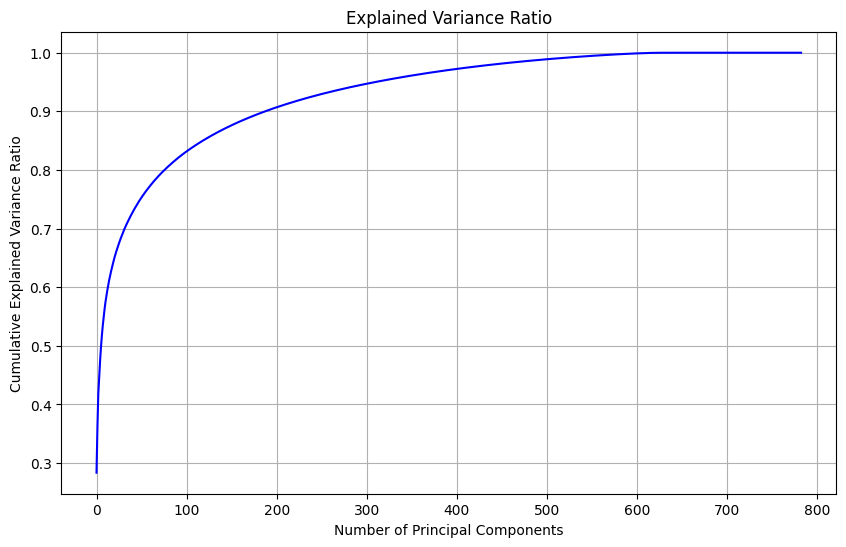

Number of components for adequate explained variance: 311


In [5]:
from sklearn.decomposition import PCA

# Function to perform PCA dimensionality reduction
def apply_pca(images):
    pca = PCA()
    images_flattened = linearize_images(images)
    pca.fit(images_flattened)
    images_pca = pca.transform(images_flattened)
    explained_variance_ratio = pca.explained_variance_ratio_
    return images_pca, explained_variance_ratio

# Perform PCA dimensionality reduction
train_images_pca, explained_variance_train = apply_pca(train_images_resized)

# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(explained_variance_train)

# Visualize explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_train), color='blue')
plt.title('Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

# Find the number of components at which explained variance is adequate
threshold_variance = 0.95  # You can adjust this threshold based on your requirements
num_components_adequate = np.argmax(cumulative_variance_ratio >= threshold_variance) + 1

print("Number of components for adequate explained variance:", num_components_adequate)

311 dimensions provides an adaquate compressed representation of our image data. 

As we can see by the graph above, reaching a 95% explained variance with 311 componenets suggests that these compononents capture a majority of the variability in our cars data. If we increased the number of components beyond this point, we will not be able to make any more substancial inferences upon our data. So, this insight allows us to make more informed decisions about how many principal components to retain for further analysis upon our data. By selecting just 311 components, we can reduce the dimentionality of our data while retaining most of the important features. 

**Linear Dimensionality Reduction of the Images using RPCA** and **Visualization Explained Variance**

Randomized Principal Component Analysis (RPCA) is a another technique for reducing the dimensionality of a dataset while preserving essential information. This method is particularly beneficial for large datasets, such as our own, as it offers computational efficiency without sacrificing accuracy.

The scikit-learn library provides an implementation of RPCA, making it easy to apply to our dataset. Before applying RPCA, it's essential to standardize the data to ensure that all variables contribute equally to the analysis. We can achieve this using the StandardScaler class from sklearn, which scales the features to have a mean of 0 and a standard deviation of 1. Once the data is standardized, we can proceed to apply RPCA, this time using the attribute 'randomized' for the solver. Now, we have to fit the RPCA model to our data using the .fit() method, which calculates the principal components based on the covariance matrix of the transformed data. Similar to PCA, RPCA requires the use of transformed data obtained through the .transform() method we used eariler. Finally, we follow the same steps as before with creating the graph, then we can visualize our explained variance.

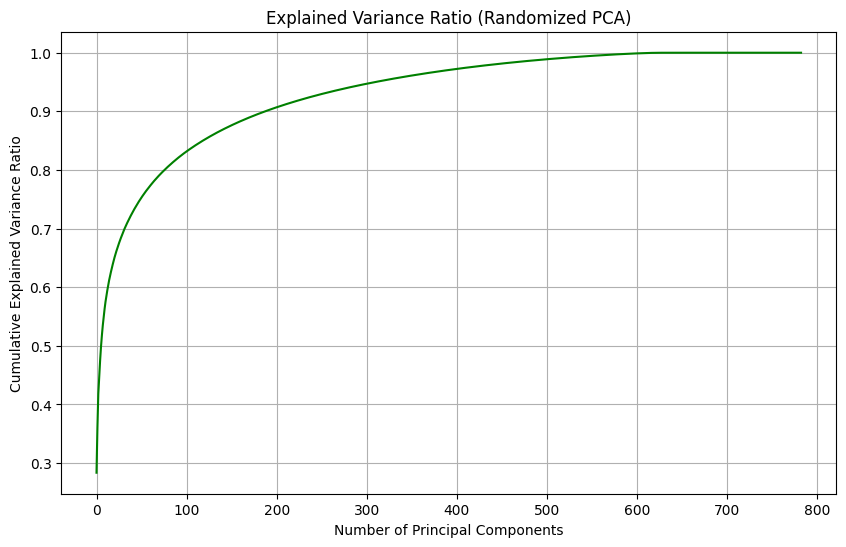

Number of components for adequate explained variance (Randomized PCA): 311


In [6]:
from sklearn.decomposition import PCA

# Function to perform Randomized PCA dimensionality reduction
def apply_rpca(images):
    rpca = PCA(svd_solver='randomized')
    images_flattened = linearize_images(images)
    rpca.fit(images_flattened)
    images_rpca = rpca.transform(images_flattened)
    explained_variance_ratio = rpca.explained_variance_ratio_
    return images_rpca, explained_variance_ratio

# Perform Randomized PCA dimensionality reduction
train_images_rpca, explained_variance_train_rpca = apply_rpca(train_images_resized)

# Calculate cumulative explained variance ratio
cumulative_variance_ratio_rpca = np.cumsum(explained_variance_train_rpca)

# Visualize explained variance ratio for Randomized PCA
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_ratio_rpca, color='green')
plt.title('Explained Variance Ratio (Randomized PCA)')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

# Find the number of components at which explained variance is adequate for Randomized PCA
threshold_variance_rpca = 0.95  # You can adjust this threshold based on your requirements
num_components_adequate_rpca = np.argmax(cumulative_variance_ratio_rpca >= threshold_variance_rpca) + 1

print("Number of components for adequate explained variance (Randomized PCA):", num_components_adequate_rpca)


Now using RPCA, we observe the same result of 311 componenents required to explain 95% of the variance, which is the same result we just saw using PCA. 

Given that both of the observations are the same, this indicates cosistency between the two dimensionality reduction techniques, and reinforces the confidence in our findings. And once again, both graphs illustrate that beyond 311 components, the increase in explained variance becomes marginal. Therefore, using 311 dimensions provides an adaquate representation of our data.

**Comparing PCA and RPCA representations**

eddie : write about comparison if our method of getting RPCA/PCA is correct, need to see prof.

**Feature Extraction using DAISY**

eddie : write about DAISY and this process

In [8]:
from skimage.feature import daisy
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def extract_daisy_features(images, step, radius, rings, histograms, orientations):
    features_list = []
    for img in images:
        features = daisy(img, step=step, radius=radius, rings=rings, histograms=histograms, orientations=orientations, visualize=False)
        features_list.append(features.ravel())
    return np.array(features_list)

# Extract DAISY features from train and test images
step = 2
radius = 4
rings = 2
histograms = 8
orientations = 8

# Use balanced images to extract DAISY features
train_features = extract_daisy_features(train_images, step, radius, rings, histograms, orientations)
test_features = extract_daisy_features(test_images_resized, step, radius, rings, histograms, orientations)

# Train a classifier using balanced features and labels
classifier = SVC(kernel='linear')
classifier.fit(train_features, train_labels)

# Predict labels for test images
predictions = classifier.predict(test_features)

# Evaluate accuracy
accuracy = accuracy_score(test_labels, predictions)
print("Classification Accuracy:", accuracy)
